In [558]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [559]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [560]:
NUM_CLASSES = 0
with open('model/keypoint_classifier/keypoint_classifier_label.csv',encoding='utf-8-sig') as f:
    reader = csv.reader(f)
    data = list(reader)
    NUM_CLASSES = len(data)
print(NUM_CLASSES)

39


# Dataset reading

In [561]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (42 * 2) + 1)))

In [562]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [563]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.85, random_state=RANDOM_SEED)



# Model building

In [564]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((42 * 2, )),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(42, activation='relu'),
    #tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(21, activation='relu'),
    #tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [565]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_172 (Dense)           (None, 42)                3570      
                                                                 
 dense_173 (Dense)           (None, 21)                903       
                                                                 
 dense_174 (Dense)           (None, 10)                220       
                                                                 
 dense_175 (Dense)           (None, 5)                 55        
                                                                 
 dense_176 (Dense)           (None, 10)                60        
                                                                 
 dense_177 (Dense)           (None, 20)                220       
                                                                 
 dense_178 (Dense)           (None, 39)              

In [566]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=1, save_weights_only=False)
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [567]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [568]:
model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=1000,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback],
)

Epoch 1/1000
390/390 [==============================] - ETA: 0s - loss: 1.9774 - accuracy: 0.3906
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
390/390 [==============================] - 2s 2ms/step - loss: 1.9774 - accuracy: 0.3906 - val_loss: 0.8241 - val_accuracy: 0.7664
Epoch 2/1000
342/390 [=========================>....] - ETA: 0s - loss: 0.4526 - accuracy: 0.8641
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
390/390 [==============================] - 0s 1ms/step - loss: 0.4327 - accuracy: 0.8716 - val_loss: 0.2846 - val_accuracy: 0.9245
Epoch 3/1000
365/390 [===========================>..] - ETA: 0s - loss: 0.2040 - accuracy: 0.9508
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
390/390 [==============================] - 0s 1ms/step - loss: 0.2019 - accuracy: 0.9514 - val_loss: 0.1800 - val_accuracy: 0.9607
Epoch 4/1000
360/390 [==========================>...] - ETA: 0s - loss: 0.1326 - accu

Epoch 28/1000
379/390 [============================>.] - ETA: 0s - loss: 0.0103 - accuracy: 0.9978
Epoch 28: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
390/390 [==============================] - 0s 1ms/step - loss: 0.0103 - accuracy: 0.9978 - val_loss: 0.0306 - val_accuracy: 0.9968
Epoch 29/1000
328/390 [========================>.....] - ETA: 0s - loss: 0.0141 - accuracy: 0.9967
Epoch 29: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
390/390 [==============================] - 0s 1ms/step - loss: 0.0133 - accuracy: 0.9969 - val_loss: 0.0224 - val_accuracy: 0.9975
Epoch 30/1000
378/390 [============================>.] - ETA: 0s - loss: 0.0100 - accuracy: 0.9977
Epoch 30: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
390/390 [==============================] - 0s 1ms/step - loss: 0.0098 - accuracy: 0.9978 - val_loss: 0.0214 - val_accuracy: 0.9978
Epoch 31/1000
376/390 [===========================>..] - ETA: 0s - loss: 0.0110

Epoch 55/1000
377/390 [============================>.] - ETA: 0s - loss: 0.0043 - accuracy: 0.9986
Epoch 55: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
390/390 [==============================] - 0s 1ms/step - loss: 0.0045 - accuracy: 0.9985 - val_loss: 0.0230 - val_accuracy: 0.9968
Epoch 56/1000
387/390 [============================>.] - ETA: 0s - loss: 0.0057 - accuracy: 0.9982
Epoch 56: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
390/390 [==============================] - 0s 1ms/step - loss: 0.0057 - accuracy: 0.9983 - val_loss: 0.0253 - val_accuracy: 0.9969
Epoch 57/1000
366/390 [===========================>..] - ETA: 0s - loss: 0.0064 - accuracy: 0.9982
Epoch 57: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
390/390 [==============================] - 0s 1ms/step - loss: 0.0070 - accuracy: 0.9981 - val_loss: 0.0273 - val_accuracy: 0.9966
Epoch 58/1000
353/390 [==========================>...] - ETA: 0s - loss: 0.0070

Epoch 82/1000
376/390 [===========================>..] - ETA: 0s - loss: 0.0024 - accuracy: 0.9994
Epoch 82: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
390/390 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.0181 - val_accuracy: 0.9985
Epoch 83/1000
389/390 [============================>.] - ETA: 0s - loss: 0.0094 - accuracy: 0.9975
Epoch 83: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
390/390 [==============================] - 0s 1ms/step - loss: 0.0094 - accuracy: 0.9975 - val_loss: 0.0231 - val_accuracy: 0.9976
Epoch 84/1000
374/390 [===========================>..] - ETA: 0s - loss: 0.0030 - accuracy: 0.9992
Epoch 84: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
390/390 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.0187 - val_accuracy: 0.9985
Epoch 85/1000
369/390 [===========================>..] - ETA: 0s - loss: 0.0064

In [569]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

69/69 [==============================] - 0s 631us/step - loss: 0.0229 - accuracy: 0.9980


In [570]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [571]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))
x = np.argmax(np.squeeze(predict_result))
print(np.squeeze(predict_result)[x])

1/1 [==============================] - 0s 47ms/step
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.7064762e-13
 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.2597197e-19 1.2912125e-36
 7.7486872e-30 0.0000000e+00 0.0000000e+00 1.3868525e-17 0.0000000e+00
 0.0000000e+00 0.0000000e+00 9.8297159e-26 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 7.4631090e-14 1.5175516e-24
 0.0000000e+00 1.0000000e+00 0.0000000e+00 3.9465074e-27 2.6247113e-20
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
31
1.0


# Confusion matrix

275/275 [==============================] - 0s 561us/step


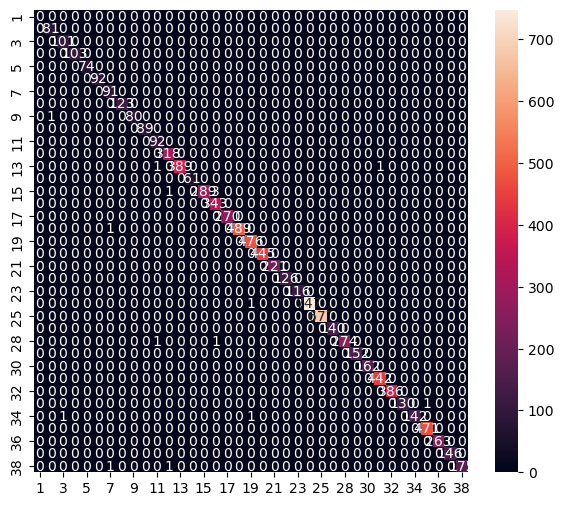

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         2
           2       0.99      1.00      0.99        81
           3       0.99      1.00      1.00       101
           4       1.00      1.00      1.00       103
           5       1.00      1.00      1.00        74
           6       1.00      1.00      1.00        92
           7       0.98      1.00      0.99        91
           8       1.00      1.00      1.00       123
           9       1.00      0.99      0.99        81
          10       1.00      1.00      1.00        89
          11       0.98      1.00      0.99        92
          12       0.99      1.00      1.00       318
          13       1.00      0.99      1.00       391
          14       1.00      1.00      1.00        61
          15       1.00      0.99      0.99       293
          16       0.99      1.00      0.99       343
     

C:\Users\kaka1\anaconda3\envs\project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kaka1\anaconda3\envs\project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kaka1\anaconda3\envs\project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kaka1\anaconda3

In [572]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [573]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [574]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\kaka1\AppData\Local\Temp\tmpifa15f3r\assets


INFO:tensorflow:Assets written to: C:\Users\kaka1\AppData\Local\Temp\tmpifa15f3r\assets


16768

# Inference test

In [575]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [576]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [577]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [578]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 2 ms


In [579]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.1691040e-13
 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.4027534e-19 3.3559280e-36
 1.3672923e-29 0.0000000e+00 0.0000000e+00 1.3043988e-17 0.0000000e+00
 0.0000000e+00 0.0000000e+00 7.1577461e-26 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.8529699e-14 9.8623597e-25
 0.0000000e+00 1.0000000e+00 0.0000000e+00 2.3259870e-27 1.8774001e-20
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
31
